# Table of content

1. [Import Data](#section-one)

2. [Data import and selection](#section-two)

3. [Predicting Heatwaves](#section-three)
4. [Predicting Floods](#section-four)
5. [Hyperparameters tuning](#section-five)
6. [Conclusion and Submission](#section-six)


<a id="section-one"></a>
# Libraries import

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set_theme()

# permet d'afficher plus de lignes et de colonnes
pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

<a id="section-two"></a>
# Data import and selection

In [78]:
url = 'https://raw.githubusercontent.com/OmdenaAI/karachi-pakistan-weather-prediction/main/src/tasks/task_3_modelling/df_final_Karachi.csv'
data = pd.read_csv(url)
data.head()

,time,city,temperature_2m_min,temperature_2m_mean,temperature_2m_max,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2010-01-01,Karachi,14.8,20.9,26.0,11.2,10.633333,0.0,0,0.0,18.3,25.6,16.25,4.38
1,2010-01-02,Karachi,15.6,20.5,25.3,9.7,10.616667,0.0,0,0.0,24.6,35.3,9.15,3.84
2,2010-01-03,Karachi,14.3,19.9,25.0,10.7,10.633333,0.0,0,0.0,16.6,28.1,16.03,3.69
3,2010-01-04,Karachi,15.0,20.4,25.6,10.6,10.650000,0.0,0,0.0,14.0,22.7,16.32,3.63
4,2010-01-05,Karachi,16.3,20.7,25.4,9.1,10.650000,0.0,0,0.0,19.3,29.2,16.37,3.55


In [79]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m_min,4966.0,22.470963,5.083169,8.600000,18.400000,24.100,26.800000,32.500000
temperature_2m_mean,4966.0,26.247382,3.986358,14.300000,23.300000,27.600,29.275000,37.100000
temperature_2m_max,4966.0,30.567861,3.645286,17.700000,28.500000,31.100,33.100000,43.200000
temp_range,4966.0,8.096899,3.121997,1.000000,5.300000,8.100,10.700000,18.200000
daylight,4966.0,12.169536,1.068760,10.583333,11.133333,12.200,13.216667,13.683333
precipitation_sum,4966.0,0.499376,3.744586,0.000000,0.000000,0.000,0.000000,119.300000
precipitation_hours,4966.0,0.677004,2.711949,0.000000,0.000000,0.000,0.000000,24.000000
precipitation_rate,4966.0,0.050230,0.241179,0.000000,0.000000,0.000,0.000000,5.680952
windspeed_10m_max,4966.0,24.021023,6.423371,9.000000,19.300000,23.700,28.200000,47.900000
windgusts_10m_max,4966.0,37.990475,9.369277,14.000000,31.300000,37.800,44.300000,79.600000


In [80]:
# convert the df index to datetime
data['time'] = pd.to_datetime(data['time'], format='%Y/%m/%d')
df_k = data.drop(columns=['city'])
df_k = df_k.set_index('time')

# reorder the columns
col_names = df_k.columns.tolist()
col_names.insert(0, col_names.pop(2))
df_k = df_k[col_names]

df_k.head()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,
2010-01-01,26.0,14.8,20.9,11.2,10.633333,0.0,0,0.0,18.3,25.6,16.25,4.38
2010-01-02,25.3,15.6,20.5,9.7,10.616667,0.0,0,0.0,24.6,35.3,9.15,3.84
2010-01-03,25.0,14.3,19.9,10.7,10.633333,0.0,0,0.0,16.6,28.1,16.03,3.69
2010-01-04,25.6,15.0,20.4,10.6,10.650000,0.0,0,0.0,14.0,22.7,16.32,3.63
2010-01-05,25.4,16.3,20.7,9.1,10.650000,0.0,0,0.0,19.3,29.2,16.37,3.55


**Features**


* **temperature_2m_max, temperature_2m_min** -> Maximum and minimum daily air temperature at 2 meters above ground

* **temp_range** ->

* **precipitation_sum** -> Sum of daily precipitation

* **precipitation_hours** -> The number of hours with rain

* **precipitation_rate** ->

* **windspeed_10m_max, windgusts_10m_max** -> Maximum wind speed and gusts on a day

* **shortwave_radiation_sum** -> The sum of solar radiaion on a given day in cities

* **et0_fao_evapotranspiration** -> Daily sum of ET₀ Reference Evapotranspiration of a well watered grass field<br>
<br>

**Unit**

* **Temperature** -> °C (°F)

* **precipitation_sum** -> mm

* **rain_sum** -> mm

* **snowfall_sum** -> cm

* **precipitation_hours** -> hours

* **Windspeed** -> km/h

* **shortwave_radiation_sum** -> MJ/m²

* **et0_fao_evapotranspiration** -> mm

<a id="section-three"></a>
# Predicting Heatwaves

I differenciate the temperature max series as there is a yearly seasonality.
I create a naive function that will give a first indication of predictability.
It is not meant to be used for prediction but more for comparison with RNN and LSTM

## Naive Differenciating

In [128]:
def naive(data, feat, start, end, shift, start_pred, end_pred, graph=False):
  """
  that function is meant to calculate the naive differencing for a give dataframe (data), feature(feat) and a start and end date.
  It returns the mean absolute percentage error MAPE.
  """

  if graph == True:
        # plot the time series and its differenciated
        data[start:end][feat].plot(grid=True, marker=".", figsize=(20, 10))
        data[start:end].shift(shift)[feat].plot(grid=True, marker=".", figsize=(25, 10))

  # Calculate the Mean Absolute Percentate Error for a given perido
  diff = data[[feat]].diff(shift)[start_pred:end_pred]
  diff = diff.abs().mean()
  target = data[[feat]][start_pred:end_pred]
  MAPE = diff / target.abs().mean()*100
  plt.show()
  return MAPE

In [130]:
features = df_k.columns
for feat in features:
  MAPE = naive(df_k, feat, '2020-01', '2022-12', 365, '2022-12-15', '2022-12-31')
  print(f'The MAPE for {feat} is {MAPE}')

The MAPE for temperature_2m_max is temperature_2m_max    10.420014
dtype: float64
The MAPE for temperature_2m_min is temperature_2m_min    18.969555
dtype: float64
The MAPE for temperature_2m_mean is temperature_2m_mean    13.607226
dtype: float64
The MAPE for temp_range is temp_range    24.512535
dtype: float64
The MAPE for daylight is daylight    0.018498
dtype: float64
The MAPE for precipitation_sum is precipitation_sum    inf
dtype: float64
The MAPE for precipitation_hours is precipitation_hours    inf
dtype: float64
The MAPE for precipitation_rate is precipitation_rate    inf
dtype: float64
The MAPE for windspeed_10m_max is windspeed_10m_max    43.06115
dtype: float64
The MAPE for windgusts_10m_max is windgusts_10m_max    39.86764
dtype: float64
The MAPE for shortwave_radiation_sum is shortwave_radiation_sum    16.073574
dtype: float64
The MAPE for et0_fao_evapotranspiration is et0_fao_evapotranspiration    30.861692
dtype: float64


## LSTM

I use TensorFlow and Keras to predict univariate target from multivariate features.

### a. Data Preparation
it includes:<br>
* creating a set for 'day-1' as the window size is 1
* include the target date for 'd day'
* normalize the features

In [81]:
# convert series to supervised learning (from https://machinelearningmastery.com/)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  #input sequence t-n, ..., t-1
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop row with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [82]:
# adapted from https://machinelearningmastery.com/
from sklearn.preprocessing import MinMaxScaler

values = df_k.values
values = values.astype('float32')

# normalize feature
minmax = MinMaxScaler(feature_range=(0,1))
values_minmaxed = minmax.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values_minmaxed, 1, 1)

# I keep the temp max (t) columns and drop all the others
# reframed.drop(reframed.columns[13:14], axis=1, inplace=True)
reframed = reframed.iloc[:, list(range(12)) + [12]]

# get the columns names right
df_k_columns = df_k.columns.tolist()
df_k_columns.append(df_k.columns[0])

reframed.columns = df_k_columns
reframed.columns.values[12] = 'temperature_2m_max (t)'

display(reframed.head())

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration,temperature_2m_max (t)
1,0.325490,0.259414,0.289474,0.593023,0.016129,0.0,0.0,0.0,0.239074,0.176829,0.533214,0.278768,0.298039
2,0.298039,0.292887,0.271930,0.505814,0.010753,0.0,0.0,0.0,0.401028,0.324695,0.279643,0.235008,0.286274
3,0.286274,0.238494,0.245614,0.563953,0.016129,0.0,0.0,0.0,0.195373,0.214939,0.525357,0.222853,0.309804
4,0.309804,0.267782,0.267544,0.558140,0.021505,0.0,0.0,0.0,0.128535,0.132622,0.535714,0.217990,0.301961
5,0.301961,0.322176,0.280702,0.470930,0.021505,0.0,0.0,0.0,0.264781,0.231707,0.537500,0.211507,0.250980


### Define and Fit Model
the date range I sued is from 2010-01-01 to 2022-12-31<br>
the 2023 values will be used for predictions

In [83]:
# adapted from https://machinelearningmastery.com/

# split into train and test sets
values = reframed.values
# we use 2010-2022 for training and testing purpose. 2023 will serve for evaluation
# train size is 80% and test size 20%
n_train_days = int(4748 * .80)

train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

Epoch 1/40
60/60 - 3s - loss: 0.1270 - val_loss: 0.0617 - 3s/epoch - 53ms/step
Epoch 2/40
60/60 - 0s - loss: 0.0585 - val_loss: 0.0522 - 261ms/epoch - 4ms/step
Epoch 3/40
60/60 - 0s - loss: 0.0498 - val_loss: 0.0444 - 279ms/epoch - 5ms/step
Epoch 4/40
60/60 - 0s - loss: 0.0432 - val_loss: 0.0394 - 261ms/epoch - 4ms/step
Epoch 5/40
60/60 - 0s - loss: 0.0393 - val_loss: 0.0370 - 240ms/epoch - 4ms/step
Epoch 6/40
60/60 - 0s - loss: 0.0374 - val_loss: 0.0360 - 269ms/epoch - 4ms/step
Epoch 7/40
60/60 - 0s - loss: 0.0364 - val_loss: 0.0351 - 247ms/epoch - 4ms/step
Epoch 8/40
60/60 - 0s - loss: 0.0355 - val_loss: 0.0343 - 222ms/epoch - 4ms/step
Epoch 9/40
60/60 - 0s - loss: 0.0352 - val_loss: 0.0344 - 273ms/epoch - 5ms/step
Epoch 10/40
60/60 - 0s - loss: 0.0349 - val_loss: 0.0337 - 298ms/epoch - 5ms/step
Epoch 11/40
60/60 - 0s - loss: 0.0346 - val_loss: 0.0335 - 385ms/epoch - 6ms/step
Epoch 12/40
60/60 - 0s - loss: 0.0344 - val_loss: 0.0335 - 397ms/epoch - 7ms/step
Epoch 13/40
60/60 - 0s - lo

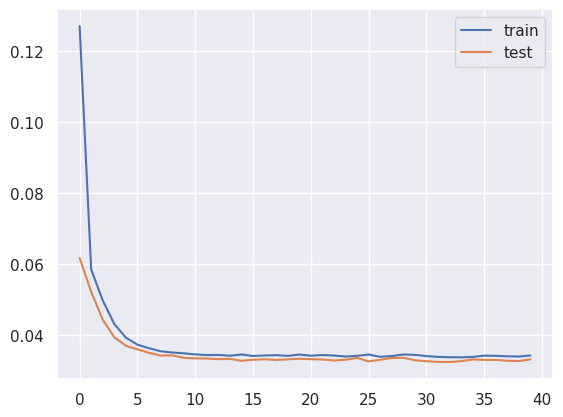

In [84]:
# adapted from https://machinelearningmastery.com/
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluate Model

In [85]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = minmax.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = minmax.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_y.mean())
print('rmse %', rmse/inv_y.mean()*100)

37/37 [==============================] - 1s 3ms/step
Test RMSE: 1.180
30.786201
rmse % 3.8319017683619396


### 30 days predictions

**note** I have doubts on the pertinence of predicting 30 days<br> nobody on earth can predict the time to 30 days so I don't really get it. <br>
on top of that, as I used a window size of 1, I guess my predictions should stick to 1 day. Anyhow I run that test but I'm not sure it makes sense or that the results are good.

In [87]:
# adapted from https://machinelearningmastery.com/

# split into train and test sets
values = reframed.values
# we use 30 days window from the 2023-01-01 to 2023-08-31
pred_size = 30
data_2023 = values[n_train_days+1:, :]
sample_2023 = data_2023[0:0+pred_size,:]

# split into input and outputs
sample_X, sample_y = sample_2023[:, :-1], sample_2023[:, -1]

# reshape input to be 3D [samples, timesteps, features]
sample_X = sample_X.reshape((sample_X.shape[0], 1, sample_X.shape[1]))

In [88]:
# make a prediction
yhat = model.predict(sample_X)

# invert scaling for forecast
sample_X = sample_X.reshape(30,12)
inv_yhat = concatenate((yhat, sample_X[:, 1:]), axis=1)

inv_yhat = minmax.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y = sample_y.reshape((len(sample_y), 1))

inv_y = concatenate((y, sample_X[:, 1:]), axis=1)
inv_y = minmax.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_y.mean())
print('rmse %', rmse/inv_y.mean()*100)

1/1 [==============================] - 0s 24ms/step
Test RMSE: 0.519
34.193336
rmse % 1.5164571659074788


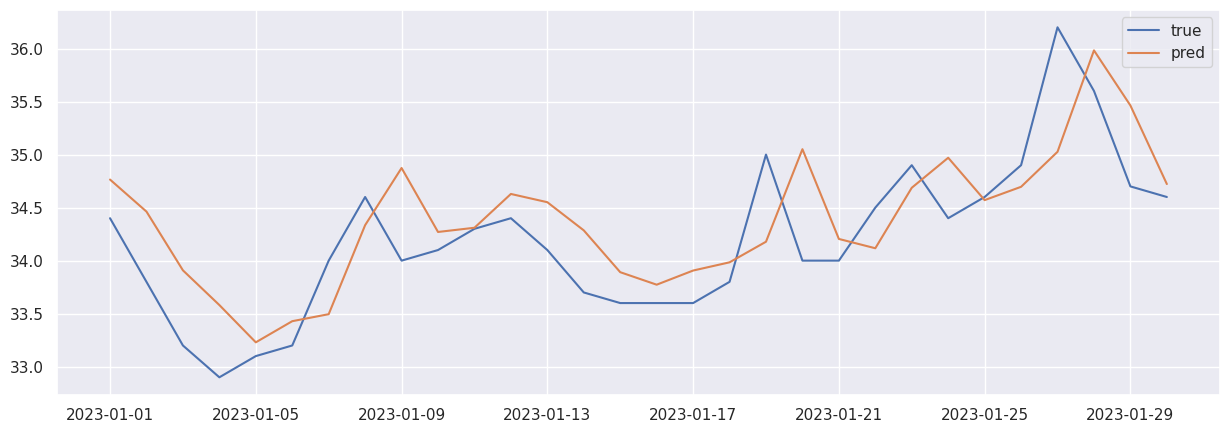

In [89]:
start_date = '2023-01-01'
end_date = '2023-01-30'

# Create a boolean mask for the desired date range
mask = (df_k.index >= start_date) & (df_k.index <= end_date)

# Select the index labels within the date range
index_range = df_k.index[mask]

plt.figure(figsize=(15,5))
plt.plot(index_range,inv_y, label='true')
plt.plot(index_range,inv_yhat, label='pred')
plt.legend()
plt.show()

<a id="section-four"></a>
# Predicting flood

In [325]:
# # puting the column 'precipitation_rate' at index = 0
# col_names = df_k.columns.tolist()
# col_names.insert(0, col_names.pop(7))
# df_k = df_k[col_names]

df_k.head()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,
2010-01-01,26.0,14.8,20.9,11.2,10.633333,0.0,0,0.0,18.3,25.6,16.25,4.38
2010-01-02,25.3,15.6,20.5,9.7,10.616667,0.0,0,0.0,24.6,35.3,9.15,3.84
2010-01-03,25.0,14.3,19.9,10.7,10.633333,0.0,0,0.0,16.6,28.1,16.03,3.69
2010-01-04,25.6,15.0,20.4,10.6,10.650000,0.0,0,0.0,14.0,22.7,16.32,3.63
2010-01-05,25.4,16.3,20.7,9.1,10.650000,0.0,0,0.0,19.3,29.2,16.37,3.55


In [326]:
# adapted from https://machinelearningmastery.com/
from sklearn.preprocessing import MinMaxScaler

values = df_k.values
values = values.astype('float32')

# normalize feature
minmax = MinMaxScaler(feature_range=(0,1))
values_minmaxed = minmax.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values_minmaxed, 1, 1)
print(reframed)
# I keep the temp max (t) columns and drop all the others
# reframed.drop(reframed.columns[13:14], axis=1, inplace=True)
reframed = reframed.iloc[:, list(range(12)) + [19]]

# get the columns names right
df_k_columns = df_k.columns.tolist()
df_k_columns.append(df_k.columns[0])

reframed.columns = df_k_columns
reframed.columns.values[12] = 'precipitation_rate (t)'

display(reframed.head(50))

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.325490   0.259414   0.289474   0.593023   0.016129   0.000000   
2      0.298039   0.292887   0.271930   0.505814   0.010753   0.000000   
3      0.286274   0.238494   0.245614   0.563953   0.016129   0.000000   
4      0.309804   0.267782   0.267544   0.558140   0.021505   0.000000   
5      0.301961   0.322176   0.280702   0.470930   0.021505   0.000000   
...         ...        ...        ...        ...        ...        ...   
4961   0.498039   0.778243   0.622807   0.127907   0.870968   0.007544   
4962   0.494118   0.769874   0.614035   0.133721   0.865591   0.004191   
4963   0.482353   0.769874   0.614035   0.116279   0.860215   0.005029   
4964   0.490196   0.761506   0.614035   0.139535   0.854839   0.000000   
4965   0.482353   0.757322   0.609649   0.133721   0.849462   0.000838   

      var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1      0.000000   0.000000   0.239

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration,precipitation_rate (t)
1,0.325490,0.259414,0.289474,0.593023,0.016129,0.000000,0.000000,0.000000,0.239074,0.176829,0.533214,0.278768,0.000000
2,0.298039,0.292887,0.271930,0.505814,0.010753,0.000000,0.000000,0.000000,0.401028,0.324695,0.279643,0.235008,0.000000
3,0.286274,0.238494,0.245614,0.563953,0.016129,0.000000,0.000000,0.000000,0.195373,0.214939,0.525357,0.222853,0.000000
4,0.309804,0.267782,0.267544,0.558140,0.021505,0.000000,0.000000,0.000000,0.128535,0.132622,0.535714,0.217990,0.000000
5,0.301961,0.322176,0.280702,0.470930,0.021505,0.000000,0.000000,0.000000,0.264781,0.231707,0.537500,0.211507,0.000000
6,0.250980,0.271967,0.241228,0.465116,0.026882,0.000000,0.000000,0.000000,0.200514,0.231707,0.529643,0.182334,0.000000
7,0.325490,0.271967,0.289474,0.575581,0.026882,0.000000,0.000000,0.000000,0.277635,0.214939,0.540357,0.243922,0.000000
8,0.305882,0.305439,0.263158,0.500000,0.026882,0.000000,0.000000,0.000000,0.434447,0.407012,0.546429,0.337115,0.000000
9,0.301961,0.259414,0.232456,0.558140,0.032258,0.000000,0.000000,0.000000,0.408740,0.379573,0.550000,0.291734,0.000000
10,0.321569,0.221757,0.236842,0.639535,0.037635,0.000000,0.000000,0.000000,0.285347,0.286585,0.554643,0.287682,0.041073


In [327]:
print(reframed['precipitation_rate'].mean())

0.008840031


In [328]:
# adapted from https://machinelearningmastery.com/

# split into train and test sets
values = reframed.values
# we use 2010-2022 for training and testing purpose. 2023 will serve for evaluation
# train size is 80% and test size 20%
n_train_days = int(4748 * .80)

train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3798, 1, 12) (3798,) (1167, 1, 12) (1167,)


In [329]:
np.mean(test_y)

0.01301982

Epoch 1/40
60/60 - 3s - loss: 0.0223 - val_loss: 0.0181 - 3s/epoch - 49ms/step
Epoch 2/40
60/60 - 0s - loss: 0.0119 - val_loss: 0.0127 - 251ms/epoch - 4ms/step
Epoch 3/40
60/60 - 0s - loss: 0.0092 - val_loss: 0.0129 - 250ms/epoch - 4ms/step
Epoch 4/40
60/60 - 0s - loss: 0.0097 - val_loss: 0.0125 - 251ms/epoch - 4ms/step
Epoch 5/40
60/60 - 0s - loss: 0.0094 - val_loss: 0.0127 - 245ms/epoch - 4ms/step
Epoch 6/40
60/60 - 0s - loss: 0.0091 - val_loss: 0.0121 - 250ms/epoch - 4ms/step
Epoch 7/40
60/60 - 0s - loss: 0.0087 - val_loss: 0.0120 - 263ms/epoch - 4ms/step
Epoch 8/40
60/60 - 0s - loss: 0.0091 - val_loss: 0.0120 - 226ms/epoch - 4ms/step
Epoch 9/40
60/60 - 0s - loss: 0.0094 - val_loss: 0.0119 - 233ms/epoch - 4ms/step
Epoch 10/40
60/60 - 0s - loss: 0.0089 - val_loss: 0.0117 - 232ms/epoch - 4ms/step
Epoch 11/40
60/60 - 0s - loss: 0.0098 - val_loss: 0.0117 - 216ms/epoch - 4ms/step
Epoch 12/40
60/60 - 0s - loss: 0.0089 - val_loss: 0.0122 - 267ms/epoch - 4ms/step
Epoch 13/40
60/60 - 0s - lo

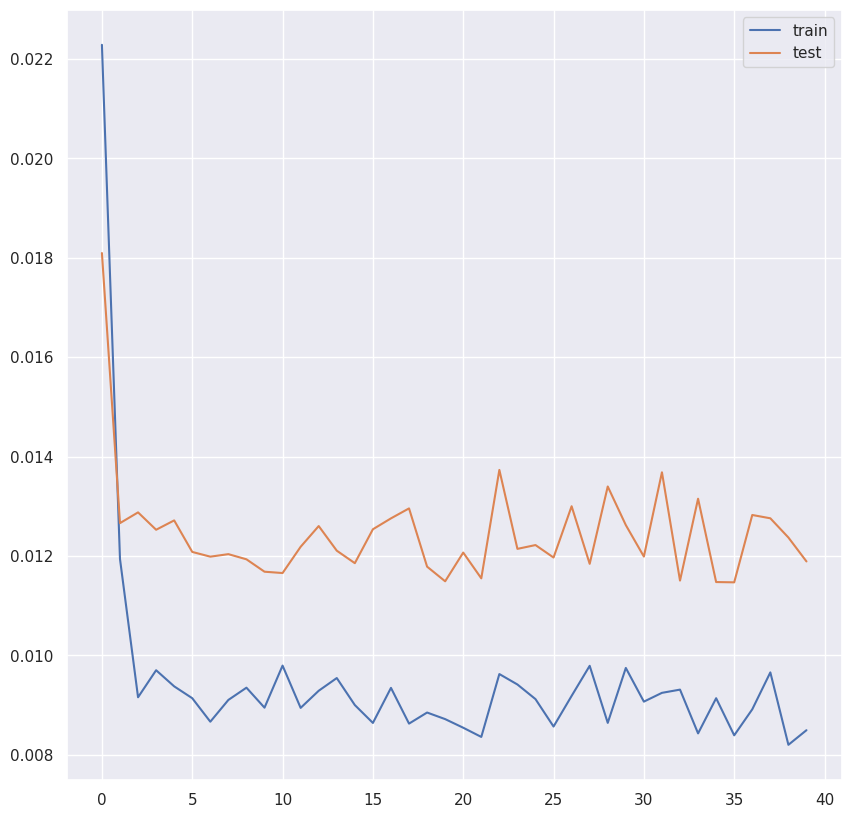

In [330]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# adapted from https://machinelearningmastery.com/
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [331]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = minmax.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = minmax.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_y.mean())
print('rmse %', rmse/inv_y.mean()*100)

37/37 [==============================] - 1s 2ms/step
Test RMSE: 1.089
18.032005
rmse % 6.0413450409756795
